In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
def read_out_tr(out_filename):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(out_filename, sep = ' ', header = None)
    df.columns = col
    return df

def get_tcp_packets(df):
    df_out = df.loc[df["pkt_type"].isin(["tcp"])]
    return df_out

def parse_trace(file):
    col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
               "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
    df = pd.read_csv(file, sep = ' ', header = None)
    df.columns = col
    df["Normalized FCT"] = 40 * 1e9  / df["Average rate"]
    return df

def humanbytes(B):
    B = float(B)
    KB = float(1000)
    MB = float(KB ** 2)
    GB = float(KB ** 3)
    TB = float(KB ** 4) 

    if B < KB:
        return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
    elif KB <= B < MB:
        return '{0:.2f} KB'.format(B/KB)
    elif MB <= B < GB:
        return '{0:.2f} MB'.format(B/MB)
    elif GB <= B < TB:
        return '{0:.2f} GB'.format(B/GB)
    elif TB <= B:
        return '{0:.2f} TB'.format(B/TB)
    
def plot_one_end2end_delay_mean_flowsize(out_filename, flow_size, tracefile, alg):
    raw_data = read_out_tr(out_filename)
    tcp_pkts = get_tcp_packets(raw_data)
    grouped = tcp_pkts.groupby(['fid', 'pkt_id'])
    fid_pkt_delay = (grouped.last()['time'] - grouped.first()['time'])* 1e6
    trace_df = parse_trace(tracefile)
    #fid_delay = fid_pkt_delay.sum(level='fid') 
    fid_delay = fid_pkt_delay.mean(level='fid') # Peixuan 0626
    trace_df['flow_delay'] = trace_df["fin_fid"].apply(lambda x: fid_delay[int(x)])
    flow_delay = trace_df[['tmp_pkts', 'fin_fid', 'flow_delay']]
    cate=pd.cut(flow_delay["tmp_pkts"], flow_size, labels=flow_size[:-1])
    delay_average = []
    for label in flow_size[:-1]:
        seg_flow_delay = flow_delay[cate == label]
        delay_average.append(seg_flow_delay.mean()['flow_delay'])
    
    print("Avg_delay of " + alg + ": ")
    print(delay_average)
    plt.plot([humanbytes(i*1500) for i in flow_size[:-1]], delay_average, label=alg)
    
    
def plot_end2end_delay_mean_flowsize(flow_size, algs):
    #directory = "/home/ovs2/eval/tcp_random_pair_32host/diff_host_4pods/4host_FID/out_tr/4p4h1000f/"
    directory = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/4host_FID/out_tr/4p4h1000f/"
    plt.figure(figsize=(18,5))
    plt.xlabel('flow size')
    plt.ylabel('delay average(us)')
    plt.title("delay average at load 0.9")
    for alg in algs:
        filename = '4p4h1000f_'+alg+'_out.tr'
        #filename = 'tcp-incast-'+alg+'/tcp_flow_1000_0.9_Topology-4hosts-4pods-random.tcl.tr'
        #tracefile = "/home/ovs2/eval/tcp_random_pair_32host/diff_host_4pods/4host_FID/tcp-incast-"+alg+"/tcp_flow_1000_0.9_Topology-4hosts-4pods-random.tcl.tr"
        tracefile = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/4host_FID/tcp-incast-"+alg+"/tcp_flow_1000_0.9_Topology-4hosts-4pods-random.tcl.tr"
        plot_one_end2end_delay_mean_flowsize(directory+filename, flow_size, tracefile, alg)
    plt.legend()
    plt.show()

Avg_delay of HRCC: 
[9.1309090909088404, 9.1586216040663295, 10.665825246633911, 11.102622430930063, 15.651807368851097, 35.85428829372767, 171.85116326631635, 247.87104655733603, 289.3171250331265, 246.85120039675502, 137.99863025300834, nan]
Avg_delay of AFQ10: 
[7.6775757575747612, 7.9833238533516253, 8.5568858840885422, 8.8679937896098462, 10.229646058287583, 18.749236546059198, 26.531404879994817, 26.377187205440841, 29.791371025568367, 28.649354932288624, 20.008401103262948, nan]
Avg_delay of AFQ100: 
[13.950303030301271, 13.719635825689178, 17.151702900996877, 17.52179198358855, 21.306844295638342, 38.286525757731731, 163.27510792858843, 239.99056704516823, 294.79734101823891, 245.03898014132818, 135.69097864644212, nan]
Avg_delay of AFQ1000: 
[54.45333333332804, 44.367263845109029, 63.836711773566634, 64.754942032858224, 71.121757179257514, 89.109968012922494, 152.30186572338346, 196.7867906364859, 256.78660522703052, 215.19608125871832, 132.64829666222434, nan]
Avg_delay of AF

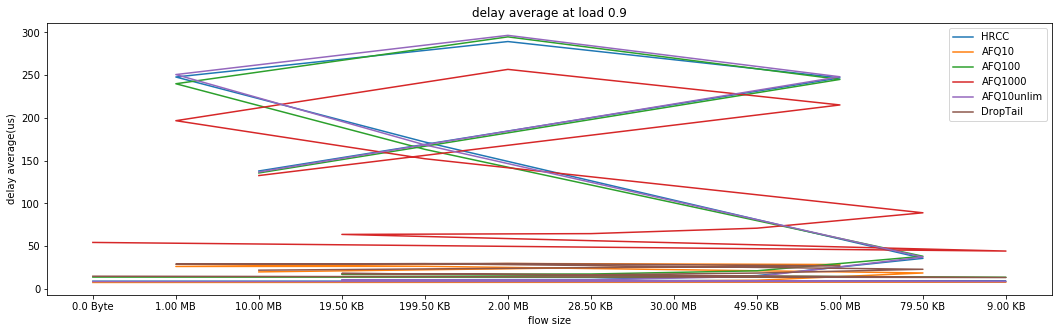

In [3]:
#algs = ['HRCC', 'AFQ10', 'AFQ100', 'AFQ1000', 'AFQ10unlim', 'BDPDropTail', 'DropTail', 'LargeDropTail']
algs = ['HRCC', 'AFQ10', 'AFQ100', 'AFQ1000', 'AFQ10unlim', 'DropTail']
#algs = ['HRCC']
flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, 20000, float('inf')]
plot_end2end_delay_mean_flowsize(flow_size, algs)


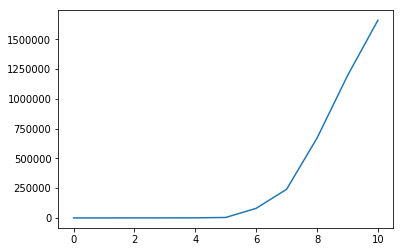

In [31]:
delay_average = [91.309090909088397, 125.39622641503857, 216.71428571423314, 350.54736842111748, 760.29365079374725, 3767.9344262293935, 80627.634615384944, 240538.19191919264, 670172.2272727266, 1193811.6750000005, 1659448.0526315712, 0]
#flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, 20000, float('inf')]
#print([humanbytes(i*1500) for i in flow_size[:-1]])
flow_size_byte = [humanbytes(i*float(1500)) for i in flow_size[:-1]]
flow_size_float = [float(0), float(6), float(13), float(19), float(33), float(53), float(133), float(667), float(1333), float(3333), float(6667), float(20000), float('inf')]
#plt.plot([humanbytes(i*1500) for i in flow_size[:-1]], delay_average)
#plt.plot(flow_size_byte[:-1], delay_average[:-1])
#plt.plot(flow_size_float[:-2], delay_average[:-1])
plt.plot(delay_average[:-1])
#print(flow_size_byte)

In [34]:
#Avg_delay of HRCC: 
delay_hrcc = [91.309090909088397, 125.39622641503857, 216.71428571423314, 350.54736842111748, 760.29365079374725, 3767.9344262293935, 80627.634615384944, 240538.19191919264, 670172.2272727266, 1193811.6750000005, 1659448.0526315712, 0]
#Avg_delay of AFQ10: 
delay_afq10 = [76.775757575747519, 109.75471698105594, 173.80219780229103, 278.87368421061149, 490.59523809531015, 2036.5245901637811, 13197.74038461521, 27697.747474747921, 71706.988636363603, 142004.73749999935, 249497.63157894425, 0]
#Avg_delay of AFQ100: 
delay_afq100 = [139.50303030301271, 186.56603773573394, 347.87912087905306, 554.0210526316165, 1031.2063492062484, 3971.4590163933358, 76986.826923075831, 232938.2929292935, 687477.22727272625, 1185810.1625000001, 1644773.9999999835, 0]
#Avg_delay of AFQ1000: 
delay_afq1000 = [544.53333333328055, 590.43396226417212, 1297.6263736262963, 2049.0526315791021, 3446.2301587301604, 9019.5573770486917, 69130.971153847975, 190853.4040404039, 597823.93181818479, 1042311.3999999976, 1607330.1052631314, 0]
#Avg_delay of AFQ10unlim: 
delay_afq10unlim = [87.333333333340292, 121.39622641509949, 207.34065934062644, 338.08421052635646, 715.99206349219867, 3950.5081967213491, 79296.442307692589, 243239.37373737351, 688262.57954545494, 1200433.9624999985, 1648373.9210526105, 0]
#Avg_delay of DropTail: 
delay_droptail = [151.45454545455928, 186.64150943384942, 373.34065934075147, 526.33684210534159, 906.08730158723017, 2373.6065573765022, 13364.624999999271, 29363.494949494616, 69400.409090909816, 133752.70000000147, 278118.18421052763, 0]


In [1]:
delay_hrcc_part = delay_hrcc[:]
delay_afq10unlim_part = afq10unlim_hrcc[:]
delay_afq10_part = afq10_hrcc[:]
delay_afq100_part = afq100_hrcc[:]
delay_afq1000_part = afq1000_hrcc[:]
delay_droptail_part = droptail_hrcc[:]


name_list = ['0-9KB', '0KB-20KB', '20KB-30KB', '30KB-50KB', '50KB-80KB', '80KB-200KB', '200KB-1MB', '1MB-2MB', '2MB-5MB', '5MB-10MB', '10MB-30MB', '>30MB']
x = list(range(len(name_list)))
total_width, n = 0.8, 4
width = total_width / n
plt.bar(x, delay_hrcc_part, width=width, label='Gearbox', tick_label=name_list, fc='purpule')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10unlim_part, width=width, label='PIFO', fc='red')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq10_part, width=width, label='AFQ10', fc='blue')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq100_part, width=width, label='AFQ100', fc='orange')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_afq1000_part, width=width, label='AFQ1000', fc='green')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, delay_droptail_part, width=width, label='DropTail', fc='grey')
plt.legend()
plt.show()

NameError: name 'delay_hrcc' is not defined

In [4]:
Avg_delay of HRCC = [9.1309090909088404, 9.1586216040663295, 10.665825246633911, 11.102622430930063, 15.651807368851097, 35.85428829372767, 171.85116326631635, 247.87104655733603, 289.3171250331265, 246.85120039675502, 137.99863025300834, nan]
Avg_delay of AFQ10 = [7.6775757575747612, 7.9833238533516253, 8.5568858840885422, 8.8679937896098462, 10.229646058287583, 18.749236546059198, 26.531404879994817, 26.377187205440841, 29.791371025568367, 28.649354932288624, 20.008401103262948, nan]
Avg_delay of AFQ100 = [13.950303030301271, 13.719635825689178, 17.151702900996877, 17.52179198358855, 21.306844295638342, 38.286525757731731, 163.27510792858843, 239.99056704516823, 294.79734101823891, 245.03898014132818, 135.69097864644212, nan]
Avg_delay of AFQ1000 = [54.45333333332804, 44.367263845109029, 63.836711773566634, 64.754942032858224, 71.121757179257514, 89.109968012922494, 152.30186572338346, 196.7867906364859, 256.78660522703052, 215.19608125871832, 132.64829666222434, nan]
Avg_delay of AFQ10unlim = [8.7333333333340271, 8.8522853995806159, 10.209215064836689, 10.704537089827886, 14.724833984338172, 37.330366381153929, 168.49833049984304, 250.71817598966831, 296.5623948911205, 248.15055366933203, 136.81624265384605, nan]
Avg_delay of DropTail = [14.957245885429185, 13.450223170580557, 18.192066779616841, 16.658862967322854, 18.645161752567155, 23.081147675509872, 29.612742859363383, 29.090755793877292, 29.858633696703215, 27.097517000020719, 22.022084453234289, nan]

SyntaxError: invalid syntax (<ipython-input-4-38fbdd257ea0>, line 1)